# Conformalized Early Stopping -- Regression

- We implement the conformalized early stopping algorithm as well as the benchmark methods on the bike sharing demand dataset provided by Hadi Fanaee Tork from Capital Bikeshare and hosted by the UCI Machine Learning Repository [1]. 

**Note: the following dataset description is copied from UCI Machine Learning Repository. **
Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues. 

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

- We follow the data cleaning process and used the same model architecture as in the conformalized quantile regression experiments https://github.com/yromano/cqr/tree/master/datasets [2]. To be specific, we standardize the features to have zero mean and unit variance and we rescale the response by dividing it by its mean absolute value

- For the benchmark methods, we randomly selected 2000 samples for training the deep neural network models, 1000 validation samples to decide the early stopped models, and additional 1000 samples for calibration. For the conformalized early stopping method, we use the same subset of selected samples but merge the training and validation samples and use the merged dataset for training. The 1000 calibration samples are used together with new test point to select the best models. For both benchmark and our proposed method, we train the model for  𝑇max=200  epochs, saving every snapshot, and compute the marginal coverage rate and size of the prediction intervals averaged over 100 test samples.

[1] Fanaee-T, Hadi, and Gama, Joao, Event labeling combining ensemble detectors and background knowledge, Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg.

[2] Yaniv Romano, Evan Patterson, Emmanuel J. Candès, Conformalized Quantile Regression, Advances in Neural Information Processing Systems (2019), https://proceedings.neurips.cc/paper/2019/file/5103c3584b063c431bd1268e9b5e76fb-Paper.pdf

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
# Python 2/3 compatibility
from __future__ import print_function, division

import itertools
import time

import torch as th
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.preprocessing import StandardScaler
from sympy import *
import pathlib
import pdb
import matplotlib.pyplot as plt

from ConformalizedES.method import CES_regression
from ConformalizedES.networks import mse_model, MSE_loss
from ConformalizedES.inference import Conformal_PI
from third_party.coverage import *

In [6]:
# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44], [250,159,181]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

def plot_loss(train_loss, val_loss):
    x = np.arange(1, len(train_loss) + 1)

    plt.figure()
    plt.plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training, validation and test loss")
    
    plt.show()

## Loading and cleaning the dataset

In [8]:
reload_dataset = True

In [9]:
if reload_dataset:
  !git clone https://github.com/yromano/cqr.git

Cloning into 'cqr'...
remote: Enumerating objects: 1152, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1152 (delta 0), reused 1 (delta 0), pack-reused 1148
Receiving objects: 100% (1152/1152), 5.14 MiB | 31.35 MiB/s, done.
Resolving deltas: 100% (728/728), done.


In [10]:
from cqr.datasets import datasets

class PrepareData(Dataset):

    def __init__(self, X, y, scale_X=False):
        if not torch.is_tensor(X):
            if scale_X:
                X = StandardScaler().fit_transform(X)
                self.X = torch.from_numpy(X)
            self.X = torch.from_numpy(X)
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)
        

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].float(), self.y[idx].float()


## The benchmark method

In [ ]:
# specify the number of samples in training, validation, calibration and test datasets
n_train = 2000
n_val = 1000
n_cal = 1000
n_test = 100 

seed = 566
np.random.seed(seed)
th.manual_seed(seed)

idx = np.random.permutation(n_train+n_val+n_cal)
idx_test = np.random.permutation(n_test)

# divide the data into proper training set and calibration set
idx_train_BM, idx_val_BM, idx_cal_BM = idx[:n_train], idx[n_train:n_val+n_train], idx[n_val+n_train: n_val+n_train + n_cal]

# load the data
X, y = datasets.GetDataset('bike', './cqr/datasets/')

# split the dataset into disjoint subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# zero mean and unit variance scaling of the train and test features
scalerX = StandardScaler()
scalerX = scalerX.fit(X_train[idx_train_BM])
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test[idx_test])

# scale the response values by dividing each by the mean absolute response
mean_ytrain = np.mean(np.abs(y_train[idx_train_BM]))
y_train = np.squeeze(y_train)/mean_ytrain
y_test = np.squeeze(y_test[idx_test])/mean_ytrain

# reshape the data
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# data splitting
X_train_BM, y_train_BM = X_train[idx_train_BM], y_train[idx_train_BM]
X_val_BM, y_val_BM = X_train[idx_val_BM], y_train[idx_val_BM]
X_cal_BM, y_cal_BM = X_train[idx_cal_BM], y_train[idx_cal_BM]

print("Size (BM): train (%d, %d), validation (%d, %d), calibration (%d, %d), test (%d, %d)" % \
      (X_train_BM.shape[0], X_train_BM.shape[1], X_val_BM.shape[0], X_val_BM.shape[1], 
       X_cal_BM.shape[0], X_cal_BM.shape[1], X_test.shape[0], X_test.shape[1]))
# sys.stdout.flush()

Size (BM): train (2000, 18), validation (1000, 18), calibration (1000, 18), test (100, 18)


In [ ]:
# set model hyperparameter
batch_size = 64
in_shape = X_train_BM.shape[1]
hidden_layer_size = 256
dropout = 0
num_epochs = 200
lr = 0.0005
wd = 1e-5

num_workers = 0

In [ ]:
train_loader = DataLoader(PrepareData(X_train_BM, y_train_BM, scale_X=False), batch_size=batch_size)
val_loader = DataLoader(PrepareData(X_val_BM, y_val_BM, scale_X=False), batch_size=batch_size, drop_last = True) 
calib_loader = DataLoader(PrepareData(X_cal_BM, y_cal_BM, scale_X=False), batch_size=1, shuffle = False, drop_last=True)
test_loader = DataLoader(PrepareData(X_test, y_test, scale_X=False), batch_size= 1, shuffle = False)

print("Dataloader size (BM): train (%d), validation (%d), calibration (%d), test (%d)" % \
      (len(train_loader), len(val_loader), len(calib_loader), len(test_loader)))

Dataloader size (BM): train (32), validation (15), calibration (1000), test (100)


In [ ]:
# intialize the model
mod = mse_model(in_shape = in_shape, hidden_size = hidden_layer_size) #, dropout = dropout
optimizer = torch.optim.Adam(mod.parameters(), lr=lr, weight_decay = wd)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")

BM_reg = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, 
                        learning_rate=lr, val_loader=val_loader, criterion= MSE_loss, optimizer=optimizer)

===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 200
learning_rate= 0.0005


In [ ]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
BM_reg.full_train(save_dir = './content', save_every = save_every)

Epoch 1 of 200, 9% 	 train_loss: 1.93  took: 0.01s
Epoch 1 of 200, 18% 	 train_loss: 1.42  took: 0.01s
Epoch 1 of 200, 28% 	 train_loss: 1.26  took: 0.01s
Epoch 1 of 200, 37% 	 train_loss: 1.00  took: 0.01s
Epoch 1 of 200, 46% 	 train_loss: 0.82  took: 0.01s
Epoch 1 of 200, 56% 	 train_loss: 1.02  took: 0.01s
Epoch 1 of 200, 65% 	 train_loss: 0.77  took: 0.01s
Epoch 1 of 200, 75% 	 train_loss: 0.83  took: 0.01s
Epoch 1 of 200, 84% 	 train_loss: 0.72  took: 0.01s
Epoch 1 of 200, 93% 	 train_loss: 0.82  took: 0.01s
val_loss = 0.66
Snapshot saved at epoch 1.
Epoch 2 of 200, 9% 	 train_loss: 0.67  took: 0.02s
Epoch 2 of 200, 18% 	 train_loss: 0.58  took: 0.01s
Epoch 2 of 200, 28% 	 train_loss: 0.62  took: 0.01s
Epoch 2 of 200, 37% 	 train_loss: 0.58  took: 0.01s
Epoch 2 of 200, 46% 	 train_loss: 0.47  took: 0.01s
Epoch 2 of 200, 56% 	 train_loss: 0.54  took: 0.01s
Epoch 2 of 200, 65% 	 train_loss: 0.42  took: 0.01s
Epoch 2 of 200, 75% 	 train_loss: 0.60  took: 0.01s
Epoch 2 of 200, 84% 	 t

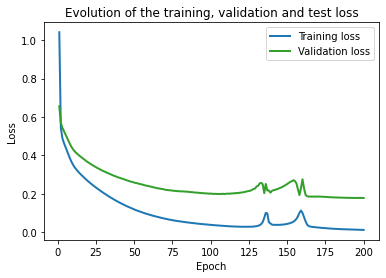

In [ ]:
# plot the loss history
plot_loss(BM_reg.train_loss_history, BM_reg.val_loss_history)

In [ ]:
# Check the benchmark models
bm_loss, bm_model, loss_history = BM_reg.select_model()

0.17811684012413026
./content/model199.pth


In [ ]:
# Split conformal prediction 
alpha = 0.1

coverage_BM = []
size_BM = []
test_losses_BM = []
pi_BM = []

C_PI = Conformal_PI(mod, device, calib_loader, alpha)

for input, response in tqdm(test_loader):
  # pi, cal_scores, test_pred, qhat = C_PI.benchmark_ICP(input, calib_loader, bm_model)
  benchmarkPI = C_PI.benchmark_ICP(input, bm_model)
  pi_BM.append(benchmarkPI[0])
  size_BM.append(benchmarkPI[0]._measure)
  coverage_BM.append(response in benchmarkPI[0])
  # evaluate the out of sample losses
  BM_reg = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, learning_rate=lr, val_loader=val_loader, verbose = False, criterion= MSE_loss, optimizer=optimizer)
  BM_reg.net.load_state_dict(torch.load(bm_model, map_location=device))
  test_loss = BM_reg.get_loss(input, response)
  test_losses_BM.append(test_loss)

wsc_coverages_BM = []

for i in np.arange(10):
  wsc_coverage = wsc_unbiased(X_test, y_test, pi_BM, M=100, delta = 0.1)
  wsc_coverages_BM.append(wsc_coverage)


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


In [ ]:
print("The marginal coverage rate is (BM) {}".format(sum(coverage_BM)/len(coverage_BM)))
print("The conditional coverage rate is (BM) {}".format(sum(wsc_coverages_BM)/len(wsc_coverages_BM)))
print("The average size is (BM) {}".format(sum(size_BM)/len(size_BM)))
print("The test loss is (BM) {}".format(sum(test_losses_BM)/len(test_losses_BM)))

The marginal coverage rate is (BM) 0.91
The conditional coverage rate is (BM) 0.8716666666666665
The average size is (BM) 1.39975426346064
The test loss is (BM) 0.15194770763372176


## Conforamlized early stopping

In [ ]:
# specify the number of samples in training, validation, calibration and test datasets
n_train = 2000
n_val = 1000
n_cal = 1000
n_test = 100 

seed = 233
np.random.seed(seed)
th.manual_seed(seed)
idx = np.random.permutation(n_train+n_val+n_cal)
idx_test = np.random.permutation(n_test)

# divide the data into proper training set and calibration set
idx_train_CES, idx_cal_CES = idx[:n_train+n_val], idx[n_train+n_val:n_train+n_val+n_cal]

# load the dataset
X, y = datasets.GetDataset('bike', './cqr/datasets/')

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# # zero mean and unit variance scaling of the train and test features
scalerX = StandardScaler()
scalerX = scalerX.fit(X_train[idx_train_CES])
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test[idx_test])

# # scale the labels by dividing each by the mean absolute response
mean_ytrain = np.mean(np.abs(y_train[idx_train_CES]))
y_train = np.squeeze(y_train)/mean_ytrain
y_test = np.squeeze(y_test[idx_test])/mean_ytrain

# reshape the data
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# data splitting
X_train_CES, y_train_CES = X_train[idx_train_CES], y_train[idx_train_CES]
X_cal_CES, y_cal_CES = X_train[idx_cal_CES], y_train[idx_cal_CES]

print("Size (CES): train (%d, %d), calibration (%d, %d), test (%d, %d)" % \
      (X_train_CES.shape[0], X_train_CES.shape[1], X_cal_CES.shape[0], X_cal_CES.shape[1], 
       X_test.shape[0], X_test.shape[1]))
# sys.stdout.flush()

Size (CES): train (3000, 18), calibration (1000, 18), test (100, 18)


In [ ]:
# set model hyperparameter
batch_size = 64
in_shape = X_train_CES.shape[1]
hidden_layer_size = 256
dropout = 0
num_epochs = 200
lr = 0.0005
wd = 1e-5
num_workers = 0

In [ ]:
train_loader = DataLoader(PrepareData(X_train_CES, y_train_CES, scale_X=False), batch_size=batch_size)
calib_loader = DataLoader(PrepareData(X_cal_CES, y_cal_CES, scale_X=False), batch_size=batch_size, drop_last=True)
test_loader = DataLoader(PrepareData(X_test, y_test, scale_X=False), batch_size= 1, shuffle = False)

print("Dataloader size (BM): train (%d), calibration (%d), test (%d)" % \
      (len(train_loader), len(calib_loader), len(test_loader)))

Dataloader size (BM): train (47), calibration (15), test (100)


In [ ]:
# intialize the model
mod = mse_model(in_shape = in_shape, hidden_size = hidden_layer_size) #, dropout = dropout
optimizer = torch.optim.Adam(mod.parameters(), lr=lr, weight_decay = wd)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")

CES_reg = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, 
                        learning_rate=lr, val_loader=calib_loader, criterion= MSE_loss, optimizer=optimizer)

===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 200
learning_rate= 0.0005


In [ ]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
CES_reg.full_train(save_dir = './content', save_every = save_every)

Epoch 1 of 200, 8% 	 train_loss: 1.54  took: 0.02s
Epoch 1 of 200, 17% 	 train_loss: 1.20  took: 0.01s
Epoch 1 of 200, 25% 	 train_loss: 0.94  took: 0.01s
Epoch 1 of 200, 34% 	 train_loss: 0.89  took: 0.01s
Epoch 1 of 200, 42% 	 train_loss: 0.85  took: 0.01s
Epoch 1 of 200, 51% 	 train_loss: 0.78  took: 0.01s
Epoch 1 of 200, 59% 	 train_loss: 0.75  took: 0.02s
Epoch 1 of 200, 68% 	 train_loss: 0.80  took: 0.02s
Epoch 1 of 200, 76% 	 train_loss: 0.55  took: 0.01s
Epoch 1 of 200, 85% 	 train_loss: 0.51  took: 0.02s
Epoch 1 of 200, 93% 	 train_loss: 0.64  took: 0.02s
val_loss = 0.56
Snapshot saved at epoch 1.
Epoch 2 of 200, 8% 	 train_loss: 0.60  took: 0.02s
Epoch 2 of 200, 17% 	 train_loss: 0.63  took: 0.01s
Epoch 2 of 200, 25% 	 train_loss: 0.56  took: 0.01s
Epoch 2 of 200, 34% 	 train_loss: 0.56  took: 0.01s
Epoch 2 of 200, 42% 	 train_loss: 0.55  took: 0.02s
Epoch 2 of 200, 51% 	 train_loss: 0.52  took: 0.02s
Epoch 2 of 200, 59% 	 train_loss: 0.56  took: 0.02s
Epoch 2 of 200, 68% 	 t

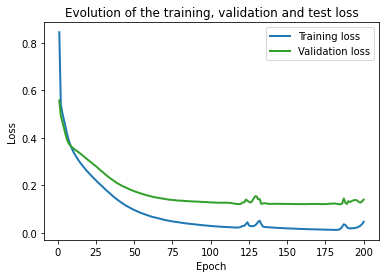

In [ ]:
plot_loss(CES_reg.train_loss_history, CES_reg.val_loss_history)

In [ ]:
# allowing empty intervals
alpha = 0.1

coverage_CES = []
size_CES = []
test_losses_CES = []
pi_CES = []

C_PI = Conformal_PI(mod, device, calib_loader, alpha)

for input, response in tqdm(test_loader):
  # find the best models
  best_models = CES_reg.select_model(input)
  # do ICP using the best models
  CESPI = C_PI.CES_icp(input, best_models, method = 'union')
  pi_CES.append(CESPI)
  # compute the size of the prediction interval
  size_single = sum([intv._measure for intv in CESPI])
  # compute the coverage of the prediction interval
  coverage_single = sum([response in intv for intv in CESPI]) > 0
  coverage_CES.append(coverage_single)
  size_CES.append(size_single)
  # pdb.set_trace()

wsc_coverages_CES = []
for i in np.arange(10):
  wsc_coverage = wsc_unbiased(X_test, y_test, pi_CES, M=100, delta = 0.1)
  wsc_coverages_CES.append(wsc_coverage)

print("The marginal coverage rate is (CES) {}".format(sum(coverage_CES)/len(coverage_CES)))
print("The conditional coverage rate is (CES) {}".format(sum(wsc_coverages_CES)/len(wsc_coverages_CES)))
print("The average size is (CES) {}".format(sum(size_CES)/len(size_CES)))
# print("The test loss is (BM) {}".format(sum(test_losses_BM)/len(test_losses_BM)))
print("The validation loss is (CES) {}".format(np.mean(CES_reg.val_loss_history[-20:])))


  0%|          | 0/100 [00:00<?, ?it/s]

elapse time (selecting best models):28.248141527175903


  2%|▏         | 2/100 [00:51<41:27, 25.38s/it]

elapse time (selecting best models):23.07154655456543


  3%|▎         | 3/100 [01:15<39:39, 24.53s/it]

elapse time (selecting best models):23.405863046646118


  4%|▍         | 4/100 [01:38<38:21, 23.97s/it]

elapse time (selecting best models):23.067991733551025
elapse time (selecting best models):23.511126041412354


  6%|▌         | 6/100 [02:28<38:44, 24.73s/it]

elapse time (selecting best models):26.188520669937134
elapse time (selecting best models):23.861112117767334


  8%|▊         | 8/100 [03:16<37:25, 24.41s/it]

elapse time (selecting best models):23.93122124671936


  9%|▉         | 9/100 [03:39<36:13, 23.88s/it]

elapse time (selecting best models):22.554059743881226


 10%|█         | 10/100 [04:02<35:16, 23.52s/it]

elapse time (selecting best models):22.58510112762451
elapse time (selecting best models):22.445112943649292


 11%|█         | 11/100 [04:24<34:31, 23.27s/it]

elapse time (selecting best models):22.62932825088501


 12%|█▏        | 12/100 [04:47<33:56, 23.14s/it]

elapse time (selecting best models):22.498380661010742


 14%|█▍        | 14/100 [05:33<32:51, 22.93s/it]

elapse time (selecting best models):22.529218435287476


 15%|█▌        | 15/100 [05:55<32:12, 22.73s/it]

elapse time (selecting best models):22.204078435897827


 16%|█▌        | 16/100 [06:17<31:39, 22.61s/it]

elapse time (selecting best models):22.223941802978516


 17%|█▋        | 17/100 [06:40<31:13, 22.57s/it]

elapse time (selecting best models):22.31110429763794
elapse time (selecting best models):22.416015625


 19%|█▉        | 19/100 [07:25<30:41, 22.73s/it]

elapse time (selecting best models):23.00784206390381


 20%|██        | 20/100 [07:48<30:10, 22.63s/it]

elapse time (selecting best models):22.267162561416626
elapse time (selecting best models):22.203362464904785


 22%|██▏       | 22/100 [08:33<29:24, 22.62s/it]

elapse time (selecting best models):22.52024555206299


 23%|██▎       | 23/100 [08:55<28:54, 22.53s/it]

elapse time (selecting best models):22.196794986724854


 24%|██▍       | 24/100 [09:18<28:30, 22.51s/it]

elapse time (selecting best models):22.275402307510376


 25%|██▌       | 25/100 [09:40<28:05, 22.48s/it]

elapse time (selecting best models):22.358887672424316
elapse time (selecting best models):22.330333709716797


 26%|██▌       | 26/100 [10:03<27:44, 22.49s/it]

elapse time (selecting best models):22.303885221481323


 27%|██▋       | 27/100 [10:25<27:23, 22.52s/it]

elapse time (selecting best models):22.31244921684265


 29%|██▉       | 29/100 [11:10<26:35, 22.48s/it]

elapse time (selecting best models):22.26761507987976


 30%|███       | 30/100 [11:33<26:13, 22.48s/it]

elapse time (selecting best models):22.420380353927612


 31%|███       | 31/100 [11:57<26:23, 22.95s/it]

elapse time (selecting best models):23.8753924369812


 32%|███▏      | 32/100 [12:20<26:03, 22.99s/it]

elapse time (selecting best models):22.935018062591553
elapse time (selecting best models):23.336272478103638


 34%|███▍      | 34/100 [13:07<25:33, 23.23s/it]

elapse time (selecting best models):23.233996391296387


 35%|███▌      | 35/100 [13:30<25:07, 23.19s/it]

elapse time (selecting best models):23.043227910995483


 36%|███▌      | 36/100 [13:54<24:51, 23.30s/it]

elapse time (selecting best models):23.496761560440063


 37%|███▋      | 37/100 [14:17<24:36, 23.44s/it]

elapse time (selecting best models):23.6065833568573


 38%|███▊      | 38/100 [14:41<24:19, 23.54s/it]

elapse time (selecting best models):23.722220182418823
elapse time (selecting best models):23.274885892868042


 40%|████      | 40/100 [15:28<23:36, 23.61s/it]

elapse time (selecting best models):23.60769534111023


 41%|████      | 41/100 [15:52<23:15, 23.66s/it]

elapse time (selecting best models):23.62543296813965


 42%|████▏     | 42/100 [16:17<23:07, 23.92s/it]

elapse time (selecting best models):24.455299615859985


 43%|████▎     | 43/100 [16:40<22:33, 23.75s/it]

elapse time (selecting best models):23.31112551689148


 44%|████▍     | 44/100 [17:03<21:56, 23.52s/it]

elapse time (selecting best models):22.83716630935669


 45%|████▌     | 45/100 [17:26<21:18, 23.25s/it]

elapse time (selecting best models):22.42726445198059


 46%|████▌     | 46/100 [17:48<20:39, 22.96s/it]

elapse time (selecting best models):22.17244553565979
elapse time (selecting best models):22.465717792510986


 48%|████▊     | 48/100 [18:33<19:46, 22.82s/it]

elapse time (selecting best models):22.529184103012085


 49%|████▉     | 49/100 [18:56<19:24, 22.83s/it]

elapse time (selecting best models):22.68051314353943
elapse time (selecting best models):23.253283262252808


 51%|█████     | 51/100 [19:43<18:46, 23.00s/it]

elapse time (selecting best models):22.733052968978882


 52%|█████▏    | 52/100 [20:05<18:18, 22.89s/it]

elapse time (selecting best models):22.468758821487427
elapse time (selecting best models):23.442643642425537


 54%|█████▍    | 54/100 [20:51<17:36, 22.96s/it]

elapse time (selecting best models):22.495820999145508


 55%|█████▌    | 55/100 [21:14<17:12, 22.95s/it]

elapse time (selecting best models):22.730901956558228
elapse time (selecting best models):22.410456895828247


 56%|█████▌    | 56/100 [21:37<16:45, 22.86s/it]

elapse time (selecting best models):22.325133562088013


 58%|█████▊    | 58/100 [22:22<15:53, 22.70s/it]

elapse time (selecting best models):22.325303554534912


 59%|█████▉    | 59/100 [22:45<15:33, 22.76s/it]

elapse time (selecting best models):22.717453479766846
elapse time (selecting best models):24.284377098083496


 61%|██████    | 61/100 [23:34<15:18, 23.56s/it]

elapse time (selecting best models):24.01745629310608


 62%|██████▏   | 62/100 [23:57<14:53, 23.52s/it]

elapse time (selecting best models):23.227069854736328
elapse time (selecting best models):22.445468425750732


 64%|██████▍   | 64/100 [24:43<14:01, 23.37s/it]

elapse time (selecting best models):23.478307962417603


 65%|██████▌   | 65/100 [25:06<13:33, 23.25s/it]

elapse time (selecting best models):22.918925046920776


 66%|██████▌   | 66/100 [25:29<13:06, 23.14s/it]

elapse time (selecting best models):22.721672296524048


 67%|██████▋   | 67/100 [25:52<12:41, 23.09s/it]

elapse time (selecting best models):22.799474954605103


 68%|██████▊   | 68/100 [26:15<12:17, 23.04s/it]

elapse time (selecting best models):22.732946634292603


 69%|██████▉   | 69/100 [26:38<11:54, 23.04s/it]

elapse time (selecting best models):22.884340047836304


 70%|███████   | 70/100 [27:01<11:27, 22.92s/it]

elapse time (selecting best models):22.599977493286133
elapse time (selecting best models):22.586073398590088


 71%|███████   | 71/100 [27:24<11:03, 22.89s/it]

elapse time (selecting best models):22.657970666885376


 73%|███████▎  | 73/100 [28:09<10:14, 22.77s/it]

elapse time (selecting best models):22.43435311317444


 74%|███████▍  | 74/100 [28:32<09:51, 22.75s/it]

elapse time (selecting best models):22.50555920600891


 75%|███████▌  | 75/100 [28:54<09:27, 22.69s/it]

elapse time (selecting best models):22.500815868377686


 76%|███████▌  | 76/100 [29:18<09:11, 22.98s/it]

elapse time (selecting best models):23.4792423248291


 77%|███████▋  | 77/100 [29:41<08:45, 22.86s/it]

elapse time (selecting best models):22.50948143005371


 78%|███████▊  | 78/100 [30:03<08:20, 22.75s/it]

elapse time (selecting best models):22.433187246322632
elapse time (selecting best models):22.767982482910156


 79%|███████▉  | 79/100 [30:26<07:59, 22.82s/it]

elapse time (selecting best models):22.47199273109436


 81%|████████  | 81/100 [31:12<07:12, 22.78s/it]

elapse time (selecting best models):22.69589900970459


 82%|████████▏ | 82/100 [31:34<06:49, 22.76s/it]

elapse time (selecting best models):22.60629177093506


 83%|████████▎ | 83/100 [31:57<06:27, 22.81s/it]

elapse time (selecting best models):22.733798027038574


 84%|████████▍ | 84/100 [32:20<06:05, 22.82s/it]

elapse time (selecting best models):22.70070195198059


 85%|████████▌ | 85/100 [32:43<05:40, 22.72s/it]

elapse time (selecting best models):22.404803037643433


 86%|████████▌ | 86/100 [33:05<05:18, 22.75s/it]

elapse time (selecting best models):22.665740489959717
elapse time (selecting best models):23.333536624908447


 88%|████████▊ | 88/100 [33:51<04:34, 22.87s/it]

elapse time (selecting best models):22.423136711120605


 89%|████████▉ | 89/100 [34:14<04:10, 22.75s/it]

elapse time (selecting best models):22.34569001197815


 90%|█████████ | 90/100 [34:37<03:47, 22.74s/it]

elapse time (selecting best models):22.558029174804688
elapse time (selecting best models):22.654995441436768


 91%|█████████ | 91/100 [35:00<03:25, 22.79s/it]

elapse time (selecting best models):23.422319889068604


 92%|█████████▏| 92/100 [35:23<03:04, 23.05s/it]

elapse time (selecting best models):33.80904841423035


 93%|█████████▎| 93/100 [35:57<03:04, 26.35s/it]

elapse time (selecting best models):38.87965679168701


 94%|█████████▍| 94/100 [36:37<03:02, 30.45s/it]

elapse time (selecting best models):35.6317720413208


 95%|█████████▌| 95/100 [37:13<02:40, 32.12s/it]

elapse time (selecting best models):31.559786319732666


 97%|█████████▋| 97/100 [38:17<01:36, 32.08s/it]

elapse time (selecting best models):31.967787504196167


 98%|█████████▊| 98/100 [38:41<00:59, 29.58s/it]

elapse time (selecting best models):23.57826328277588


 99%|█████████▉| 99/100 [39:12<00:30, 30.02s/it]

elapse time (selecting best models):30.90749216079712
elapse time (selecting best models):26.420557737350464


100%|██████████| 100/100 [39:39<00:00, 23.80s/it]


The marginal coverage rate is (CES) 0.91
The conditional coverage rate is (CES) 0.0
The average size is (CES) 1.33746396950654
The validation loss is (CES) 0.12977511007338763


In [ ]:
wsc_coverages_CES = []

for i in np.arange(10):
  wsc_coverage = wsc_unbiased(X_test, y_test, pi_CES, M=100, delta = 0.1, method = 'union')
  wsc_coverages_CES.append(wsc_coverage)

In [ ]:
print("The conditional coverage rate is (CES) {}".format(sum(wsc_coverages_CES)/len(wsc_coverages_CES)))

The conditional coverage rate is (CES) 0.8959090909090911


## The benchmark method if ignoring exchangeability

In this section we investgate the case when we simply ignore the exchangeability in test sample and calibration sample. We select the best model and do calibration on the same set of hold-out data

First let's investigate the cases when the size of the calibration set is small (n_calib = 10). When n_calib is small, a single test sample should play a more important role in achieving marginal validity, hence ignoring the exchangeability between test samples and calibration samples will invalidate marginal coverage rate.

In [11]:
# specify the number of samples in training, validation, calibration and test datasets
n_train = 2000
n_val = 1000
n_cal = 10
n_test = 100 

seed = 233
np.random.seed(seed)
th.manual_seed(seed)
idx = np.random.permutation(n_train+n_val+n_cal)
idx_test = np.random.permutation(n_test)

# divide the data into proper training set and calibration set, 3000 for training, 1000 for choosing best model and calibration
idx_train_BM_noexc, idx_cal_BM_noexc = idx[:n_train+n_val], idx[n_train+n_val:n_train+n_val+n_cal]

# load the dataset
X, y = datasets.GetDataset('bike', './cqr/datasets/')

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# # zero mean and unit variance scaling of the train and test features
scalerX = StandardScaler()
scalerX = scalerX.fit(X_train[idx_train_BM_noexc])
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test[idx_test])

# # scale the labels by dividing each by the mean absolute response
mean_ytrain = np.mean(np.abs(y_train[idx_train_BM_noexc]))
y_train = np.squeeze(y_train)/mean_ytrain
y_test = np.squeeze(y_test[idx_test])/mean_ytrain

# reshape the data
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# data splitting
X_train_BM_noexc, y_train_BM_noexc = X_train[idx_train_BM_noexc], y_train[idx_train_BM_noexc]
X_cal_BM_noexc, y_cal_BM_noexc = X_train[idx_cal_BM_noexc], y_train[idx_cal_BM_noexc]

print("Size (BM_noexc): train (%d, %d), calibration (%d, %d), test (%d, %d)" % \
      (X_train_BM_noexc.shape[0], X_train_BM_noexc.shape[1], X_cal_BM_noexc.shape[0], X_cal_BM_noexc.shape[1], 
       X_test.shape[0], X_test.shape[1]))
# sys.stdout.flush()

Size (BM_noexc): train (3000, 18), calibration (10, 18), test (100, 18)


In [12]:
# set model hyperparameter
batch_size = 64
in_shape = X_train_BM_noexc.shape[1]
hidden_layer_size = 256
dropout = 0
num_epochs = 200
lr = 0.0005
wd = 1e-5

num_workers = 0

In [13]:
train_loader = DataLoader(PrepareData(X_train_BM_noexc, y_train_BM_noexc, scale_X=False), batch_size=batch_size)
calib_loader = DataLoader(PrepareData(X_cal_BM_noexc, y_cal_BM_noexc, scale_X=False), batch_size=1, drop_last=True)
test_loader = DataLoader(PrepareData(X_test, y_test, scale_X=False), batch_size= 1, shuffle = False)

print("Dataloader size (BM): train (%d), calibration (%d), test (%d)" % \
      (len(train_loader), len(calib_loader), len(test_loader)))

Dataloader size (BM): train (47), calibration (10), test (100)


In [14]:
# intialize the model
mod = mse_model(in_shape = in_shape, hidden_size = hidden_layer_size) #, dropout = dropout
optimizer = torch.optim.Adam(mod.parameters(), lr=lr, weight_decay = wd)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")

BM_reg_noexc = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, 
                        learning_rate=lr, val_loader=calib_loader, criterion= MSE_loss, optimizer=optimizer)

===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 200
learning_rate= 0.0005


In [15]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
BM_reg_noexc.full_train(save_dir = './content', save_every = save_every)

Epoch 1 of 200, 8% 	 train_loss: 1.55  took: 0.06s
Epoch 1 of 200, 17% 	 train_loss: 1.07  took: 0.01s
Epoch 1 of 200, 25% 	 train_loss: 0.98  took: 0.01s
Epoch 1 of 200, 34% 	 train_loss: 0.97  took: 0.01s
Epoch 1 of 200, 42% 	 train_loss: 1.07  took: 0.01s
Epoch 1 of 200, 51% 	 train_loss: 0.70  took: 0.01s
Epoch 1 of 200, 59% 	 train_loss: 0.68  took: 0.01s
Epoch 1 of 200, 68% 	 train_loss: 0.78  took: 0.01s
Epoch 1 of 200, 76% 	 train_loss: 0.64  took: 0.01s
Epoch 1 of 200, 85% 	 train_loss: 0.56  took: 0.01s
Epoch 1 of 200, 93% 	 train_loss: 0.58  took: 0.01s
val_loss = 0.29
Snapshot saved at epoch 1.
Epoch 2 of 200, 8% 	 train_loss: 0.61  took: 0.01s
Epoch 2 of 200, 17% 	 train_loss: 0.53  took: 0.01s
Epoch 2 of 200, 25% 	 train_loss: 0.57  took: 0.01s
Epoch 2 of 200, 34% 	 train_loss: 0.65  took: 0.01s
Epoch 2 of 200, 42% 	 train_loss: 0.66  took: 0.01s
Epoch 2 of 200, 51% 	 train_loss: 0.41  took: 0.01s
Epoch 2 of 200, 59% 	 train_loss: 0.42  took: 0.01s
Epoch 2 of 200, 68% 	 t

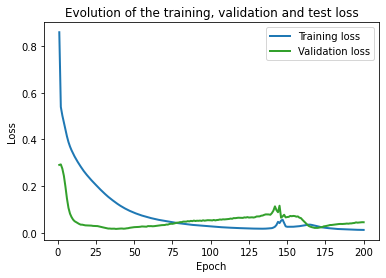

In [16]:
# plot the loss history
plot_loss(BM_reg_noexc.train_loss_history, BM_reg_noexc.val_loss_history)

In [17]:
# Check the benchmark models
bm_loss_noexc, bm_model_noexc, loss_history_noexc = BM_reg_noexc.select_model()

0.016458112729014828
./content/model38.pth


In [18]:
print("The validation loss is (BM_noexc) {}".format(np.mean(BM_reg_noexc.val_loss_history[-20:])))

The validation loss is (BM_noexc) 0.04027568268220904


In [20]:
# Split conformal prediction 
alpha = 0.1

coverage_BM_noexc = []
size_BM_noexc = []
test_losses_BM_noexc = []
pi_BM_noexc = []

C_PI = Conformal_PI(mod, device, calib_loader, alpha)

for input, response in tqdm(test_loader):
  # pi, cal_scores, test_pred, qhat = C_PI.benchmark_ICP(input, calib_loader, bm_model)
  benchmarkPI = C_PI.benchmark_ICP(input, bm_model_noexc)
  pi_BM_noexc.append(benchmarkPI[0])
  size_BM_noexc.append(benchmarkPI[0]._measure)
  coverage_BM_noexc.append(response in benchmarkPI[0])
  # evaluate the out of sample losses
  BM_reg_noexc_temp = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, learning_rate=lr, val_loader=calib_loader, verbose = False, criterion= MSE_loss, optimizer=optimizer)
  BM_reg_noexc_temp.net.load_state_dict(torch.load(bm_model_noexc, map_location=device))
  test_loss = BM_reg_noexc_temp.get_loss(input, response)
  test_losses_BM_noexc.append(test_loss)

wsc_coverages_BM_noexc = []

for i in np.arange(10):
  wsc_coverage = wsc_unbiased(X_test, y_test, pi_BM_noexc, M=100, delta = 0.1)
  wsc_coverages_BM_noexc.append(wsc_coverage)

print("The marginal coverage rate is (BM_noexc) {}".format(sum(coverage_BM_noexc)/len(coverage_BM_noexc)))
print("The conditional coverage rate is (BM_noexc) {}".format(np.nanmean(wsc_coverages_BM_noexc)))
print("The average size is (BM_noexc) {}".format(sum(size_BM_noexc)/len(size_BM_noexc)))
print("The test loss is (BM_noexc) {}".format(sum(test_losses_BM_noexc)/len(test_losses_BM_noexc)))



100%|██████████| 100/100 [00:01<00:00, 71.13it/s]


The marginal coverage rate is (BM_noexc) 0.78
The conditional coverage rate is (BM_noexc) 0.6473015873015873
The average size is (BM_noexc) 0.592337718307972
The test loss is (BM_noexc) 0.1868955927533432


Then let's investigate the cases when the size of the calibration set is large (n_calib = 1000). When n_calib is large, a single test sample should not have much effect in changing the loss functions, hence ignoring the exchangeability between test samples and calibration samples may not invalidate marginal coverage rate.

In [ ]:
# specify the number of samples in training, validation, calibration and test datasets
n_train = 2000
n_val = 1000
n_cal = 1000
n_test = 100 

seed = 233
np.random.seed(seed)
th.manual_seed(seed)
idx = np.random.permutation(n_train+n_val+n_cal)
idx_test = np.random.permutation(n_test)

# divide the data into proper training set and calibration set, 3000 for training, 1000 for choosing best model and calibration
idx_train_BM_noexc, idx_cal_BM_noexc = idx[:n_train+n_val], idx[n_train+n_val:n_train+n_val+n_cal]

# load the dataset
X, y = datasets.GetDataset('bike', './cqr/datasets/')

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# # zero mean and unit variance scaling of the train and test features
scalerX = StandardScaler()
scalerX = scalerX.fit(X_train[idx_train_BM_noexc])
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test[idx_test])

# # scale the labels by dividing each by the mean absolute response
mean_ytrain = np.mean(np.abs(y_train[idx_train_BM_noexc]))
y_train = np.squeeze(y_train)/mean_ytrain
y_test = np.squeeze(y_test[idx_test])/mean_ytrain

# reshape the data
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# data splitting
X_train_BM_noexc, y_train_BM_noexc = X_train[idx_train_BM_noexc], y_train[idx_train_BM_noexc]
X_cal_BM_noexc, y_cal_BM_noexc = X_train[idx_cal_BM_noexc], y_train[idx_cal_BM_noexc]

print("Size (BM_noexc): train (%d, %d), calibration (%d, %d), test (%d, %d)" % \
      (X_train_BM_noexc.shape[0], X_train_BM_noexc.shape[1], X_cal_BM_noexc.shape[0], X_cal_BM_noexc.shape[1], 
       X_test.shape[0], X_test.shape[1]))
# sys.stdout.flush()

Size (BM_noexc): train (3000, 18), calibration (1000, 18), test (100, 18)


In [ ]:
# set model hyperparameter
batch_size = 64
in_shape = X_train_BM_noexc.shape[1]
hidden_layer_size = 256
dropout = 0
num_epochs = 200
lr = 0.0005
wd = 1e-5

num_workers = 0

In [ ]:
train_loader = DataLoader(PrepareData(X_train_BM_noexc, y_train_BM_noexc, scale_X=False), batch_size=batch_size)
calib_loader = DataLoader(PrepareData(X_cal_BM_noexc, y_cal_BM_noexc, scale_X=False), batch_size=1, drop_last=True)
test_loader = DataLoader(PrepareData(X_test, y_test, scale_X=False), batch_size= 1, shuffle = False)

print("Dataloader size (BM): train (%d), calibration (%d), test (%d)" % \
      (len(train_loader), len(calib_loader), len(test_loader)))

Dataloader size (BM): train (47), calibration (1000), test (100)


In [ ]:
# intialize the model
mod = mse_model(in_shape = in_shape, hidden_size = hidden_layer_size) #, dropout = dropout
optimizer = torch.optim.Adam(mod.parameters(), lr=lr, weight_decay = wd)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")

BM_reg_noexc = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, 
                        learning_rate=lr, val_loader=calib_loader, criterion= MSE_loss, optimizer=optimizer)

===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 200
learning_rate= 0.0005


In [ ]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
BM_reg_noexc.full_train(save_dir = './content', save_every = save_every)

Epoch 1 of 200, 8% 	 train_loss: 1.54  took: 0.01s
Epoch 1 of 200, 17% 	 train_loss: 1.20  took: 0.01s
Epoch 1 of 200, 25% 	 train_loss: 0.94  took: 0.01s
Epoch 1 of 200, 34% 	 train_loss: 0.89  took: 0.01s
Epoch 1 of 200, 42% 	 train_loss: 0.85  took: 0.01s
Epoch 1 of 200, 51% 	 train_loss: 0.78  took: 0.01s
Epoch 1 of 200, 59% 	 train_loss: 0.75  took: 0.01s
Epoch 1 of 200, 68% 	 train_loss: 0.80  took: 0.01s
Epoch 1 of 200, 76% 	 train_loss: 0.55  took: 0.01s
Epoch 1 of 200, 85% 	 train_loss: 0.51  took: 0.02s
Epoch 1 of 200, 93% 	 train_loss: 0.64  took: 0.02s
val_loss = 0.56
Snapshot saved at epoch 1.
Epoch 2 of 200, 8% 	 train_loss: 0.60  took: 0.01s
Epoch 2 of 200, 17% 	 train_loss: 0.63  took: 0.01s
Epoch 2 of 200, 25% 	 train_loss: 0.56  took: 0.01s
Epoch 2 of 200, 34% 	 train_loss: 0.56  took: 0.02s
Epoch 2 of 200, 42% 	 train_loss: 0.55  took: 0.02s
Epoch 2 of 200, 51% 	 train_loss: 0.52  took: 0.01s
Epoch 2 of 200, 59% 	 train_loss: 0.56  took: 0.01s
Epoch 2 of 200, 68% 	 t

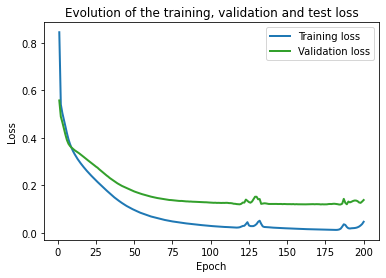

In [ ]:
# plot the loss history
plot_loss(BM_reg_noexc.train_loss_history, BM_reg_noexc.val_loss_history)

In [ ]:
# Check the benchmark models
bm_loss_noexc, bm_model_noexc, loss_history_noexc = BM_reg_noexc.select_model()

0.11898752960117825
./content/model184.pth


In [ ]:
print("The validation loss is (BM_noexc) {}".format(np.mean(BM_reg_noexc.val_loss_history[-20:])))

The validation loss is (BM_noexc) 0.12834548215132793


In [ ]:
# Split conformal prediction 
alpha = 0.1

coverage_BM_noexc = []
size_BM_noexc = []
test_losses_BM_noexc = []
pi_BM_noexc = []

C_PI = Conformal_PI(mod, device, calib_loader, alpha)

for input, response in tqdm(test_loader):
  # pi, cal_scores, test_pred, qhat = C_PI.benchmark_ICP(input, calib_loader, bm_model)
  benchmarkPI = C_PI.benchmark_ICP(input, bm_model_noexc)
  pi_BM_noexc.append(benchmarkPI[0])
  size_BM_noexc.append(benchmarkPI[0]._measure)
  coverage_BM_noexc.append(response in benchmarkPI[0])
  # evaluate the out of sample losses
  BM_reg_noexc_temp = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, learning_rate=lr, val_loader=val_loader, verbose = False, criterion= MSE_loss, optimizer=optimizer)
  BM_reg_noexc_temp.net.load_state_dict(torch.load(bm_model_noexc, map_location=device))
  test_loss = BM_reg_noexc_temp.get_loss(input, response)
  test_losses_BM_noexc.append(test_loss)

wsc_coverages_BM_noexc = []

for i in np.arange(10):
  wsc_coverage = wsc_unbiased(X_test, y_test, pi_BM_noexc, M=100, delta = 0.1)
  wsc_coverages_BM_noexc.append(wsc_coverage)

print("The marginal coverage rate is (BM_noexc) {}".format(sum(coverage_BM_noexc)/len(coverage_BM_noexc)))
print("The conditional coverage rate is (BM_noexc) {}".format(np.nanmean(wsc_coverages_BM_noexc)))
print("The average size is (BM_noexc) {}".format(sum(size_BM_noexc)/len(size_BM_noexc)))
print("The test loss is (BM_noexc) {}".format(sum(test_losses_BM_noexc)/len(test_losses_BM_noexc)))



100%|██████████| 100/100 [00:26<00:00,  3.75it/s]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


The marginal coverage rate is (BM_noexc) 0.93
The conditional coverage rate is (BM_noexc) 0.9666666666666667
The average size is (BM_noexc) 1.07138704180717
The test loss is (BM_noexc) 0.09557244484713578
